In [1]:
import sys
import os
from IPython.core.interactiveshell import InteractiveShell
from platform import python_version
print(python_version())
InteractiveShell.ast_node_interactivity = "all"
print("My working directory:\n" + os.getcwd())

3.6.9
My working directory:
/home/dsxuser/work


In [7]:
#!pip install pgeocode
#!pip install folium

In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
%matplotlib inline 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Get Geo coordinates information
from pgeocode import Nominatim

print('Libraries imported.')

Libraries imported.


### Some Useful functions

In [8]:
# Get nearby Venues for each city
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        #print(len(venues_list))
    #print(len(venues_list),len(venues_list[1]),len(venues_list[0][0]))
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    print(nearby_venues.shape)
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Get top common venues in a row
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# A function to return a list of columns for table creation use later
def create_columns(num_top_venues, name):
    indicators = ['st', 'nd', 'rd']
    columns = [name]
    
    for i in range(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
        except:
            columns.append('{}th Most Common Venue'.format(i+1))
        
    return columns

#Belows are functions for clustering
# set number of clusters
def get_kmeans_labels(city_grouped, kclusters):
    
    city_grouped_clustering = city_grouped.drop('NEIGHBORHOOD', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    return kmeans.labels_

# add clustering labels
def get_city_merged(kmeans_labels, df_PostCodeM_adj, neighborhoods_venues_sorted):
    
    temp = neighborhoods_venues_sorted.copy()
    temp.insert(0, 'Cluster Labels', kmeans_labels)
    city_merged = df_PostCodeM_adj

    # merge city_grouped with city_data to add latitude/longitude for each neighborhood
    city_merged = city_merged.join(temp.set_index('NEIGHBORHOOD'), on='Neighborhood')

    city_merged["Cluster Labels"].replace(np.nan, 0, inplace=True)
    city_merged[["Cluster Labels"]] = city_merged[["Cluster Labels"]].astype('int')
    
    return city_merged

# create map
def create_map(df_PostCodeM_adj, kclusters,city_merged):
    map_clusters = folium.Map(location=[df_PostCodeM_adj.iloc[0,3], df_PostCodeM_adj.iloc[0,4]], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['Neighborhood'], city_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

#To create a full function for above steps
def full_clustering(city_grouped, kclusters, df_PostCodeCity_adj, neighborhoods_venues_sorted):
    kmeans_labels_ = get_kmeans_labels(city_grouped, kclusters)
    city_merged = get_city_merged(kmeans_labels_, df_PostCodeCity_adj, neighborhoods_venues_sorted)
    map_clusters = create_map(df_PostCodeCity_adj, kclusters,city_merged)
    
    return map_clusters

# for selecting clustering number using eyebrow rule
# Get wss for a specific k number of cluster
def get_kmeans_wss(city_grouped, kclusters):
    
    city_grouped_clustering = city_grouped.drop('NEIGHBORHOOD', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    return kmeans.inertia_

# Get wss for different k number of cluster and draw a line graph to check the elbow
def get_wss_graph(kclusters, city_grouped, ylim):
    kmeans_wss = []

    for item in kclusters:
        kmeans_wss.append(get_kmeans_wss(city_grouped, item))

    
    df_kmeans = pd.DataFrame(kmeans_wss,
                        columns = ['WSS'],
                        index = kclusters)
    df_kmeans.index.set_names('K', inplace = True)

    df_kmeans.index = df_kmeans.index.map(int)
    df_kmeans.plot(kind='line', figsize=(15,9), ylim = ylim)
    plt.xlabel('k')
    plt.ylabel('WSS')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    return df_kmeans

<h1>Clustering for different big cities</h1>


<ol>
    <li><a href="#New York City">New York City</a></li>
    <li><a href="#Toronto">Toronto</a></li>
    <li><a href="#London">London</a></li>
</ol>

<br>
<hr>

<div id="New York City">
    <h2>New York City</h2>
</div>

### Get the Postal Code

In [9]:
#Get Borough, Neighborhood and ZIP Codes info of NYC
temp = pd.read_html('https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm')
df_PostCodeNYC = pd.DataFrame(temp[0])
#df_PostCodeM.columns = df_PostCodeM.iloc[0]
#df_PostCodeM.drop([0], inplace = True)
#df_PostCodeM.reset_index(drop=True, inplace=True)
df_PostCodeNYC.head()
df_PostCodeNYC.shape

,Borough,Neighborhood,ZIP Codes
0,Bronx,Central Bronx,"10453, 10457, 10460"
1,Bronx,Bronx Park and Fordham,"10458, 10467, 10468"
2,Bronx,High Bridge and Morrisania,"10451, 10452, 10456"
3,Bronx,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474"
4,Bronx,Kingsbridge and Riverdale,"10463, 10471"


(42, 3)

In [10]:
#Only select one ZIP Code
temp = []
for item in df_PostCodeNYC['ZIP Codes']:
    temp.append((item.split(','))[0])

df_PostCodeNYC['Postcode'] = pd.DataFrame(temp)
df_PostCode_adj = df_PostCodeNYC.drop('ZIP Codes',axis=1)
df_PostCode_adj.head()
df_PostCode_adj.to_excel('PostCodeNYC.xlsx', sheet_name = 'Sheet1')

,Borough,Neighborhood,Postcode
0,Bronx,Central Bronx,10453
1,Bronx,Bronx Park and Fordham,10458
2,Bronx,High Bridge and Morrisania,10451
3,Bronx,Hunts Point and Mott Haven,10454
4,Bronx,Kingsbridge and Riverdale,10463


### Get the geographical coordinates of the neighborhoods

In [11]:
#use PyPl pgeocode package find geographical coordinates
nomi = Nominatim('US')
Latitude = []
Longitude = []

for item in df_PostCode_adj['Postcode']:
    Geo_Coord = nomi.query_postal_code(item)
    Latitude.append(Geo_Coord.loc['latitude'])
    Longitude.append(Geo_Coord.loc['longitude'])

Latitude_df = pd.DataFrame(Latitude)
Longitude_df = pd.DataFrame(Longitude)
df_PostCode_adj['Latitude'] = Latitude_df
df_PostCode_adj['Longitude'] = Longitude_df
df_PostCode_adj.head()

,Borough,Neighborhood,Postcode,Latitude,Longitude
0,Bronx,Central Bronx,10453,40.8520,-73.9129
1,Bronx,Bronx Park and Fordham,10458,40.8633,-73.8895
2,Bronx,High Bridge and Morrisania,10451,40.8222,-73.9217
3,Bronx,Hunts Point and Mott Haven,10454,40.8085,-73.9198
4,Bronx,Kingsbridge and Riverdale,10463,40.8798,-73.9067


In [12]:
#Check to see if there is something missing
df_anynull = df_PostCode_adj.isnull()
df_anynull.describe()

,Borough,Neighborhood,Postcode,Latitude,Longitude
count,42,42,42,42,42
unique,1,1,1,1,1
top,False,False,False,False,False
freq,42,42,42,42,42


In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_PostCode_adj['Borough'].unique()),
        df_PostCode_adj.shape[0]
    )
)

The dataframe has 5 boroughs and 42 neighborhoods.


### Get nearby venures

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
lat = 40.8520
lng = -73.9129
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng,
    radius, 
    LIMIT)
results = requests.get(url).json()['response']['groups'][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4b855228f964a520865631e3',
   'name': 'My Pizza',
   'location': {'address': '1723 Dr Martin L King Jr Blvd',
    'crossStreet': 'bwtn 176th St & Macombs Rd',
    'lat': 40.849670435102155,
    'lng': -73.91681699790597,
    'labeledLatLngs': [{'label': 'display',
      'lat': 40.849670435102155,
      'lng': -73.91681699790597}],
    'distance': 419,
    'postalCode': '10453',
    'cc': 'US',
    'city': 'Bronx',
    'state': 'NY',
    'country': 'United States',
    'formattedAddress': ['1723 Dr Martin L King Jr Blvd (bwtn 176th St & Macombs Rd)',
     'Bronx, NY 10453',
     'United States']},
   'categories': [{'id': '4bf58dd8d48988d1ca941735',
     'name': 'Pizza Place',
     'pluralName': 'Pizza Places',
     'shortName': 'Pizza',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
      's

In [16]:
NYC_venues = getNearbyVenues(names=df_PostCode_adj['Neighborhood'],
                             latitudes=df_PostCode_adj['Latitude'],
                             longitudes=df_PostCode_adj['Longitude']
                            )

(1924, 7)


In [17]:
# For each Neighborhood, how many venue types do we have
NYC_venues.head()
NYC_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(NYC_venues['Venue Category'].unique())))
print('There are {} uniques Neighborhood.'.format(len(NYC_venues['Neighborhood'].unique())))
NYC_venues.to_excel('NYCVenues.xlsx', sheet_name = 'Sheet1')

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Bronx,40.852,-73.9129,My Pizza,40.849670,-73.916817,Pizza Place
1,Central Bronx,40.852,-73.9129,Accra Resturant,40.853871,-73.908421,African Restaurant
2,Central Bronx,40.852,-73.9129,Bravo Supermarkets,40.854107,-73.914162,Grocery Store
3,Central Bronx,40.852,-73.9129,Papa John's Pizza,40.852429,-73.908976,Pizza Place
4,Central Bronx,40.852,-73.9129,Chase Bank,40.850425,-73.916183,Bank


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Borough Park,43,43,43,43,43,43
Bronx Park and Fordham,62,62,62,62,62,62
Bushwick and Williamsburg,17,17,17,17,17,17
Canarsie and Flatlands,26,26,26,26,26,26
Central Bronx,38,38,38,38,38,38
Central Brooklyn,19,19,19,19,19,19
Central Harlem,63,63,63,63,63,63
Central Queens,23,23,23,23,23,23
Chelsea and Clinton,100,100,100,100,100,100


There are 266 uniques categories.
There are 42 uniques Neighborhood.


### Clustering

#### Clustering data preparation

In [18]:
# one hot encoding
City_onehot = pd.get_dummies(NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
City_onehot['NEIGHBORHOOD'] = NYC_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [City_onehot.columns[-1]] + list(City_onehot.columns[:-1])
City_onehot = City_onehot[fixed_columns]

City_onehot.head()
City_onehot.shape

,NEIGHBORHOOD,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Automotive Shop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Theater,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Bronx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

(1924, 267)

In [19]:
# group and take a mean of the frequency of occurence
NYC_grouped = City_onehot.groupby('NEIGHBORHOOD').mean().reset_index()
NYC_grouped.head()
NYC_grouped.shape

,NEIGHBORHOOD,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Automotive Shop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Theater,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Borough Park,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046512,0.0,0.0,0.0

(42, 267)

In [20]:
num_top_venues = 10
name = 'NEIGHBORHOOD'

columns = create_columns(num_top_venues, name)

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted[name] = NYC_grouped['NEIGHBORHOOD']

for i in range(NYC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[i, 1:] = return_most_common_venues(NYC_grouped.iloc[i, :], num_top_venues)

neighborhoods_venues_sorted.head()

,NEIGHBORHOOD,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Borough Park,Chinese Restaurant,Convenience Store,Pizza Place,Bakery,Pharmacy,Bank,Grocery Store,Italian Restaurant,Bagel Shop,Asian Restaurant
1,Bronx Park and Fordham,Deli / Bodega,Sandwich Place,Spanish Restaurant,Pizza Place,Coffee Shop,Plaza,Shoe Store,Chinese Restaurant,Fast Food Restaurant,Supplement Shop
2,Bushwick and Williamsburg,Mexican Restaurant,Bakery,Pizza Place,Farmers Market,Music Venue,Discount Store,Café,Thrift / Vintage Store,Spanish Restaurant,Ramen Restaurant
3,Canarsie and Flatlands,Bakery,Italian Restaurant,Discount Store,Pizza Place,Martial Arts Dojo,Women's Store,Café,Cosmetics Shop,Restaurant,Liquor Store
4,Central Bronx,Pizza Place,Chinese Restaurant,Bakery,Grocery Store,Donut Shop,Supermarket,Bank,Bus Station,Metro Station,Wings Joint


#### Clustering

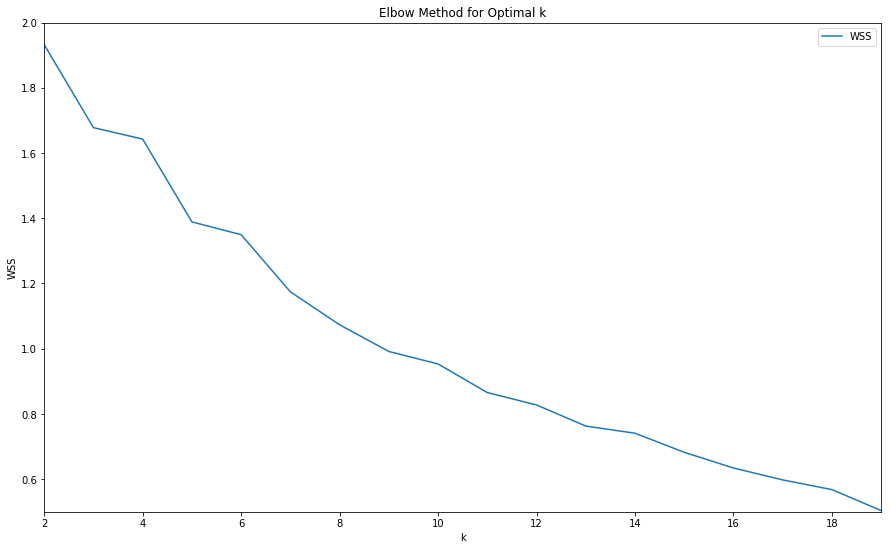

In [21]:
# try different numbers of clustering for NYC
kclusters = np.arange(2,20)
ylim = (0.5,2)
df_kmeans = get_wss_graph(kclusters, NYC_grouped, ylim)

In [22]:
df_kmeans['WSS Diff'] = df_kmeans['WSS'] - df_kmeans['WSS'].shift(1)
df_kmeans

,WSS,WSS Diff
K,,
2,1.932332,NaN
3,1.677820,-0.254512
4,1.642648,-0.035173
5,1.388803,-0.253845
6,1.349575,-0.039228
7,1.174458,-0.175117
8,1.073414,-0.101044
9,0.991533,-0.081881
10,0.953236,-0.038296


From above graph and table, it seem the number 8 Cluster is the best one.

In [25]:
kclusters = 7
kmeans_labels_ = get_kmeans_labels(NYC_grouped, kclusters)
NYC_merged = get_city_merged(kmeans_labels_, df_PostCode_adj, neighborhoods_venues_sorted)
NYC_merged.head()
full_clust = full_clustering(NYC_grouped, kclusters, df_PostCode_adj, neighborhoods_venues_sorted)
full_clust

,Borough,Neighborhood,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Central Bronx,10453,40.8520,-73.9129,0,Pizza Place,Chinese Restaurant,Bakery,Grocery Store,Donut Shop,Supermarket,Bank,Bus Station,Metro Station,Wings Joint
1,Bronx,Bronx Park and Fordham,10458,40.8633,-73.8895,1,Deli / Bodega,Sandwich Place,Spanish Restaurant,Pizza Place,Coffee Shop,Plaza,Shoe Store,Chinese Restaurant,Fast Food Restaurant,Supplement Shop
2,Bronx,High Bridge and Morrisania,10451,40.8222,-73.9217,1,Ice Cream Shop,Southern / Soul Food Restaurant,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Pharmacy,Shopping Mall,Sporting Goods Shop,Donut Shop,Food Court
3,Bronx,Hunts Point and Mott Haven,10454,40.8085,-73.9198,0,Pizza Place,Donut Shop,Chinese Restaurant,Mobile Phone Shop,Playground,Mexican Restaurant,Metro Station,Fruit & Vegetable Store,Discount Store,Diner
4,Bronx,Kingsbridge and Riverdale,10463,40.8798,-73.9067,1,Supermarket,Sandwich Place,Pizza Place,Spanish Restaurant,Mexican Restaurant,Donut Shop,Latin American Restaurant,Steakhouse,Flower Shop,Breakfast Spot


In [26]:
NYC_merged.groupby('Cluster Labels').count()

,Borough,Neighborhood,Postcode,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
1,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


### Cluster in detail: 


### Since there is only 1 unit in cluster 2-4 and 2 units in cluster 6, we focus only on 0, 1, 5.

In [27]:
NYC_merged.loc[NYC_merged['Cluster Labels'] == 0, 
               NYC_merged.columns[[1] + list(range(5, NYC_merged.shape[1]))]].head(10)

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Bronx,0,Pizza Place,Chinese Restaurant,Bakery,Grocery Store,Donut Shop,Supermarket,Bank,Bus Station,Metro Station,Wings Joint
3,Hunts Point and Mott Haven,0,Pizza Place,Donut Shop,Chinese Restaurant,Mobile Phone Shop,Playground,Mexican Restaurant,Metro Station,Fruit & Vegetable Store,Discount Store,Diner
9,Borough Park,0,Chinese Restaurant,Convenience Store,Pizza Place,Bakery,Pharmacy,Bank,Grocery Store,Italian Restaurant,Bagel Shop,Asian Restaurant
10,Canarsie and Flatlands,0,Bakery,Italian Restaurant,Discount Store,Pizza Place,Martial Arts Dojo,Women's Store,Café,Cosmetics Shop,Restaurant,Liquor Store
11,Southern Brooklyn,0,Pizza Place,Bakery,Lounge,Arts & Crafts Store,Food & Drink Shop,Men's Store,Baseball Field,Bar,Donut Shop,Fish Market
14,East New York and New Lots,0,Pizza Place,Discount Store,Supermarket,Deli / Bodega,Jewelry Store,Sandwich Place,Grocery Store,Bus Line,Train Station,Mediterranean Restaurant
34,Rockaways,0,Food & Drink Shop,Beach,Pharmacy,Deli / Bodega,Chinese Restaurant,Donut Shop,Bus Stop,Metro Station,Fried Chicken Joint,Supermarket


In [28]:
NYC_merged.loc[NYC_merged['Cluster Labels'] == 1, 
               NYC_merged.columns[[1] + list(range(5, NYC_merged.shape[1]))]].head()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bronx Park and Fordham,1,Deli / Bodega,Sandwich Place,Spanish Restaurant,Pizza Place,Coffee Shop,Plaza,Shoe Store,Chinese Restaurant,Fast Food Restaurant,Supplement Shop
2,High Bridge and Morrisania,1,Ice Cream Shop,Southern / Soul Food Restaurant,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Pharmacy,Shopping Mall,Sporting Goods Shop,Donut Shop,Food Court
4,Kingsbridge and Riverdale,1,Supermarket,Sandwich Place,Pizza Place,Spanish Restaurant,Mexican Restaurant,Donut Shop,Latin American Restaurant,Steakhouse,Flower Shop,Breakfast Spot
7,Central Brooklyn,1,Park,Pizza Place,Pool,Burger Joint,Food,Mobile Phone Shop,Donut Shop,Discount Store,Performing Arts Venue,Clothing Store
13,Flatbush,1,Caribbean Restaurant,Bank,Pharmacy,Bakery,Mobile Phone Shop,Liquor Store,Basketball Court,Supermarket,Fried Chicken Joint,Fish Market


In [29]:
NYC_merged.loc[NYC_merged['Cluster Labels'] == 5, 
               NYC_merged.columns[[1] + list(range(5, NYC_merged.shape[1]))]].head(10)

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Southeast Bronx,5,Fast Food Restaurant,Donut Shop,Liquor Store,Sandwich Place,Supermarket,Restaurant,Bus Line,Gym / Fitness Center,Medical Center,Park
8,Southwest Brooklyn,5,Italian Restaurant,Cosmetics Shop,Spa,Bagel Shop,Middle Eastern Restaurant,Bar,Mobile Phone Shop,Greek Restaurant,Pharmacy,Grocery Store
12,Northwest Brooklyn,5,Bakery,Yoga Studio,Deli / Bodega,Pizza Place,Park,Gym,Asian Restaurant,Mexican Restaurant,Bagel Shop,Burger Joint
15,Greenpoint,5,Bar,Pizza Place,Wine Bar,Coffee Shop,Mexican Restaurant,Yoga Studio,Dive Bar,Burger Joint,Café,South American Restaurant
18,Central Harlem,5,Park,Coffee Shop,Café,Southern / Soul Food Restaurant,Mexican Restaurant,Seafood Restaurant,Restaurant,Bakery,Grocery Store,Plaza
19,Chelsea and Clinton,5,Gym / Fitness Center,Coffee Shop,Salad Place,Pizza Place,Spa,Bakery,Sandwich Place,Deli / Bodega,Restaurant,Martial Arts Dojo
21,Gramercy Park and Murray Hill,5,Bar,Italian Restaurant,Pizza Place,Bagel Shop,Thrift / Vintage Store,Comedy Club,Cocktail Bar,Mexican Restaurant,Grocery Store,American Restaurant
22,Greenwich Village and Soho,5,Italian Restaurant,Clothing Store,Café,Boutique,Coffee Shop,American Restaurant,Art Gallery,French Restaurant,Sporting Goods Shop,Sushi Restaurant
23,Lower Manhattan,5,Sandwich Place,Coffee Shop,Gym / Fitness Center,Hotel,Italian Restaurant,Park,Spa,Cocktail Bar,American Restaurant,French Restaurant
24,Lower East Side,5,Mexican Restaurant,Bar,Cocktail Bar,Coffee Shop,Chinese Restaurant,Art Gallery,Ice Cream Shop,Asian Restaurant,American Restaurant,Vegetarian / Vegan Restaurant


<h2>Conclusion: from above tables, we can roughly define:</h2>

<ol>
    <li>Cluster 0 China Town: many restaurants, especially Chinease restaurants with supermarket and grocery stores.</li>
    <li>Cluster 1 Neigborhood: fast food with other neighborhood retail.</li>
    <li>Cluster 5 Downtown: all kinds of restaurant, bar, retail stores and other shops.</li>
</ol>

<hr>

<div id="Toronto">
    <h2>Toronto</h2>
</div>

### Get the Postal Code

In [33]:
#Get Borough, Neighborhood and ZIP Codes info of Toronto
temp = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df_PostCodeToronto = pd.DataFrame(temp[0])
#df_PostCodeM.columns = df_PostCodeM.iloc[0]
#df_PostCodeM.drop([0], inplace = True)
#df_PostCodeM.reset_index(drop=True, inplace=True)
df_PostCodeToronto.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
df_PostCodeToronto.head()
df_PostCodeToronto.shape

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


(287, 3)

In [34]:
# Drop rows with 'Not assigned' Borough
df_PostCode_adj = df_PostCodeToronto[df_PostCodeToronto['Borough'] != 'Not assigned']
df_PostCode_adj.reset_index(drop=True, inplace=True)
df_PostCode_adj.shape

# Replace the 'Not assigned' Neighborhood with the value of borough
for i in range(df_PostCode_adj.shape[0]):
    if df_PostCode_adj.iloc[i]['Neighborhood'] == 'Not assigned':
        df_PostCode_adj.iloc[i]['Neighborhood'] = df_PostCode_adj.iloc[i]['Borough']
        
# Check if there is still not assigned
(df_PostCode_adj['Neighborhood']=='Not assigned').unique()

# Merge neighborhoods with the same postal code
#A function to create a dataframe with merged neighborhoods with the same postal code
def merge_neighbor(temp):
    a = str()
    for item in temp['Neighborhood']:
        a = a + item +', '
    result_list = [temp.iloc[0,0], temp.iloc[0,1], a[0:-2]]
    result_df = pd.DataFrame(result_list, index=['Postcode', 'Borough', 'Neighborhood']).T
    return result_df

#get all the postal code (no repetition)
Postcode = df_PostCode_adj['Postcode'].unique()

#merge neighborhoods for each postal code
for item in Postcode:
    temp = df_PostCode_adj[df_PostCode_adj['Postcode'] == item]
    result_df = merge_neighbor(temp)
    df_PostCode_adj = df_PostCode_adj[df_PostCode_adj['Postcode'] != item]
    df_PostCode_adj = df_PostCode_adj.append(result_df, ignore_index=True, sort=False)

(210, 3)

array([False])

In [35]:
df_PostCode_adj.head(5)
df_PostCode_adj.shape

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


(103, 3)

### Get the geographical coordinates of the neighborhoods

In [36]:
#use PyPl pgeocode package find geographical coordinates
nomi = Nominatim('CA')
Latitude = []
Longitude = []

for item in df_PostCode_adj['Postcode']:
    Geo_Coord = nomi.query_postal_code(item)
    Latitude.append(Geo_Coord.loc['latitude'])
    Longitude.append(Geo_Coord.loc['longitude'])

Latitude_df = pd.DataFrame(Latitude)
Longitude_df = pd.DataFrame(Longitude)
df_PostCode_adj['Latitude'] = Latitude_df
df_PostCode_adj['Longitude'] = Longitude_df
df_PostCode_adj.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,Harbourfront,43.6555,-79.3626
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.7223,-79.4504
4,M7A,Downtown Toronto,Queen's Park,43.6641,-79.3889


In [37]:
#Check to see if there is something missing
df_anynull = df_PostCode_adj.isnull()
df_anynull.describe()
df_anynull['Latitude'].value_counts()
df_anynull['Longitude'].value_counts()
df_PostCode_adj[df_anynull['Latitude'] == True]

,Postcode,Borough,Neighborhood,Latitude,Longitude
count,103,103,103,103,103
unique,1,1,1,2,2
top,False,False,False,False,False
freq,103,103,103,102,102


False    102
True       1
Name: Latitude, dtype: int64

False    102
True       1
Name: Longitude, dtype: int64

,Postcode,Borough,Neighborhood,Latitude,Longitude
76,M7R,Mississauga,Canada Post Gateway Processing Centre,NaN,NaN


In [38]:
# Drop this row
df_PostCode_adj.drop(76, inplace=True)
df_PostCode_adj.reset_index(drop=True, inplace=True)
df_PostCode_adj.shape

(102, 5)

In [39]:
#Check again
df_anynull = df_PostCode_adj.isnull()
df_anynull.describe()

,Postcode,Borough,Neighborhood,Latitude,Longitude
count,102,102,102,102,102
unique,1,1,1,1,1
top,False,False,False,False,False
freq,102,102,102,102,102


In [40]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_PostCode_adj['Borough'].unique()),
        df_PostCode_adj.shape[0]
    )
)

The dataframe has 10 boroughs and 102 neighborhoods.


### Get nearby venures

In [41]:
# The code was removed by Watson Studio for sharing.

In [42]:
lat = 43.7545
lng = -79.3300
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng,
    radius, 
    LIMIT)
results = requests.get(url).json()['response']['groups'][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
   'name': 'Brookbanks Park',
   'location': {'address': 'Toronto',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.751976046055574,
      'lng': -79.33214044722958}],
    'distance': 329,
    'cc': 'CA',
    'city': 'Toronto',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
   'categories': [{'id': '4bf58dd8d48988d163941735',
     'name': 'Park',
     'pluralName': 'Parks',
     'shortName': 'Park',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-4e8d9dcdd5fbbbb6b3003c7b-0'},
 {'reasons': {'count': 0,
   'items': [{'

In [43]:
Toronto_venues = getNearbyVenues(names=df_PostCode_adj['Neighborhood'],
                             latitudes=df_PostCode_adj['Latitude'],
                             longitudes=df_PostCode_adj['Longitude']
                            )

(2265, 7)


In [44]:
# For each Neighborhood, how many venue types do we have
Toronto_venues.head()
Toronto_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
print('There are {} uniques Neighborhood.'.format(len(Toronto_venues['Neighborhood'].unique())))
Toronto_venues.to_excel('TorontoVenues.xlsx', sheet_name = 'Sheet1')

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7545,-79.3300,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.7545,-79.3300,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
2,Parkwoods,43.7545,-79.3300,GreenWin pool,43.756232,-79.333842,Pool
3,Parkwoods,43.7545,-79.3300,Variety Store,43.751974,-79.333114,Food & Drink Shop
4,Victoria Village,43.7276,-79.3148,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",12,12,12,12,12,12
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Downsview North, Wilson Heights",6,6,6,6,6,6
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,90,90,90,90,90,90


There are 265 uniques categories.
There are 98 uniques Neighborhood.


### Clustering

#### Clustering data preparation

In [45]:
# one hot encoding
City_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
City_onehot['NEIGHBORHOOD'] = Toronto_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [City_onehot.columns[-1]] + list(City_onehot.columns[:-1])
City_onehot = City_onehot[fixed_columns]

City_onehot.head()
City_onehot.shape

,NEIGHBORHOOD,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

(2265, 266)

In [46]:
# group and take a mean of the frequency of occurence
Toronto_grouped = City_onehot.groupby('NEIGHBORHOOD').mean().reset_index()
Toronto_grouped.head()
Toronto_grouped.shape

,NEIGHBORHOOD,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.03,0.01,0.0,0.03,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.01,0.03,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.0,0.0,0.02

(98, 266)

In [47]:
num_top_venues = 10
name = 'NEIGHBORHOOD'

columns = create_columns(num_top_venues, name)

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted[name] = Toronto_grouped['NEIGHBORHOOD']

for i in range(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[i, 1:] = return_most_common_venues(Toronto_grouped.iloc[i, :], num_top_venues)

neighborhoods_venues_sorted.head()

,NEIGHBORHOOD,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Restaurant,Bar,Gastropub,Gym,Asian Restaurant,Japanese Restaurant,American Restaurant
1,Agincourt,Breakfast Spot,Skating Rink,Badminton Court,Latin American Restaurant,Shanghai Restaurant,Yoga Studio,Falafel Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Sushi Restaurant,Pharmacy,Farmers Market,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Yoga Studio
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Liquor Store,Beer Store,Caribbean Restaurant,Coffee Shop,Fried Chicken Joint,Pizza Place,Hardware Store,Fast Food Restaurant,Pharmacy
4,"Alderwood, Long Branch",Pizza Place,Athletics & Sports,Coffee Shop,Dance Studio,Pub,Gym,Convenience Store,Pharmacy,Sandwich Place,Farmers Market


#### Clustering

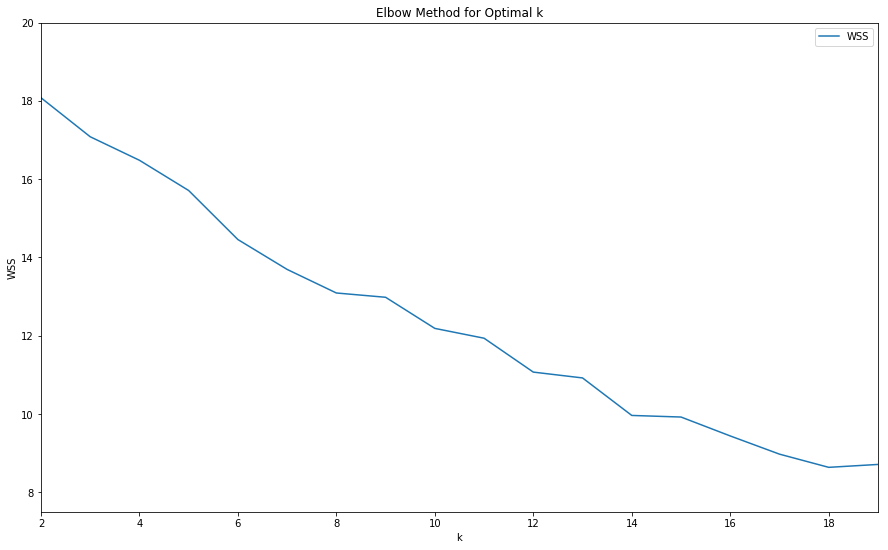

In [48]:
# try different numbers of clustering for NYC
kclusters = np.arange(2,20)
ylim = (7.5,20)
df_kmeans = get_wss_graph(kclusters, Toronto_grouped, ylim)

In [49]:
df_kmeans['WSS Diff'] = df_kmeans['WSS'] - df_kmeans['WSS'].shift(1)
df_kmeans

,WSS,WSS Diff
K,,
2,18.079042,NaN
3,17.082677,-0.996365
4,16.481616,-0.601060
5,15.709200,-0.772416
6,14.456100,-1.253100
7,13.692914,-0.763186
8,13.090651,-0.602263
9,12.981026,-0.109625
10,12.185948,-0.795078


From above graph and table, it seem the number 12 Cluster is the best one.

In [64]:
kclusters = 12
kmeans_labels_ = get_kmeans_labels(Toronto_grouped, kclusters)
Toronto_merged = get_city_merged(kmeans_labels_, df_PostCode_adj, neighborhoods_venues_sorted)
Toronto_merged.head()
full_clust = full_clustering(Toronto_grouped, kclusters, df_PostCode_adj, neighborhoods_venues_sorted)
full_clust

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.7545,-79.3300,7,Bus Stop,Food & Drink Shop,Pool,Park,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
1,M4A,North York,Victoria Village,43.7276,-79.3148,6,Hockey Arena,Intersection,Park,Portuguese Restaurant,Coffee Shop,French Restaurant,Pizza Place,Harbor / Marina,Dim Sum Restaurant,Fast Food Restaurant
2,M5A,Downtown Toronto,Harbourfront,43.6555,-79.3626,6,Coffee Shop,Restaurant,Yoga Studio,Breakfast Spot,Electronics Store,Thai Restaurant,Bakery,Pub,Italian Restaurant,Event Space
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.7223,-79.4504,6,Clothing Store,Coffee Shop,Cosmetics Shop,Electronics Store,Toy / Game Store,Men's Store,Sandwich Place,Jewelry Store,Food Court,Sushi Restaurant
4,M7A,Downtown Toronto,Queen's Park,43.6641,-79.3889,6,Gym,Pharmacy,Park,Burrito Place,Diner,College Cafeteria,Sushi Restaurant,Portuguese Restaurant,Coffee Shop,Ramen Restaurant


In [65]:
Toronto_merged.groupby('Cluster Labels').count()

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,14,14,14,14,14,11,11,11,11,11,11,11,11,11,11
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
6,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60
7,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Cluster in detail: 


### Since there is only 1 unit in cluster 1, 2, 4, 8-11, and 3 units for 7, we only focus on 0, 3, 5, 6.

In [66]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, 
               Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,East York,0,Pizza Place,Fast Food Restaurant,Gym / Fitness Center,Breakfast Spot,Gastropub,Bank,Intersection,Bus Line,Pharmacy,Curling Ice
10,North York,0,Pizza Place,Mediterranean Restaurant,Gas Station,Latin American Restaurant,Fast Food Restaurant,Ice Cream Shop,Japanese Restaurant,Grocery Store,Event Space,Eastern European Restaurant
11,Etobicoke,0,Pizza Place,Construction & Landscaping,Tea Room,Sandwich Place,Coffee Shop,Chinese Restaurant,Wine Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
18,Scarborough,0,Pizza Place,Electronics Store,Fast Food Restaurant,Coffee Shop,Liquor Store,Burger Joint,Sandwich Place,Food & Drink Shop,Breakfast Spot,Discount Store
28,North York,0,Pizza Place,Middle Eastern Restaurant,Coffee Shop,Fried Chicken Joint,Deli / Bodega,Mediterranean Restaurant,Fish & Chips Shop,Field,Fish Market,Fast Food Restaurant
51,Scarborough,0,Ice Cream Shop,Pizza Place,Bistro,Sandwich Place,Bank,Coffee Shop,Discount Store,Pharmacy,Cuban Restaurant,Cosmetics Shop
60,North York,0,Pizza Place,Grocery Store,Discount Store,Mobile Phone Shop,Liquor Store,Caribbean Restaurant,Gas Station,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place
62,Central Toronto,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Etobicoke,0,Pizza Place,Flea Market,Sandwich Place,Middle Eastern Restaurant,Ice Cream Shop,Supermarket,Chinese Restaurant,Coffee Shop,Yoga Studio,Electronics Store
76,Etobicoke,0,Pharmacy,Supermarket,Bus Line,Chinese Restaurant,Beer Store,Bank,Sandwich Place,Gas Station,Shopping Mall,Pizza Place


In [67]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, 
               Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough,3,Spa,Grocery Store,Yoga Studio,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farmers Market
56,York,3,Fast Food Restaurant,Playground,Coffee Shop,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
84,Scarborough,3,Sushi Restaurant,Pharmacy,Farmers Market,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Yoga Studio
88,Etobicoke,3,Grocery Store,Liquor Store,Beer Store,Caribbean Restaurant,Coffee Shop,Fried Chicken Joint,Pizza Place,Hardware Store,Fast Food Restaurant,Pharmacy
89,Scarborough,3,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Other Great Outdoors,Coffee Shop,Grocery Store,Sandwich Place,Pharmacy,Event Space,Falafel Restaurant


In [68]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, 
               Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,North York,5,Gym,River,Park,Yoga Studio,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
21,York,5,Park,Sporting Goods Shop,Mexican Restaurant,Bakery,Beer Store,Fast Food Restaurant,Gym,Market,Fish & Chips Shop,Field
27,North York,5,Residential Building (Apartment / Condo),Park,Yoga Studio,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
35,East York,5,Park,Convenience Store,Rental Car Location,Greek Restaurant,Intersection,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
36,Downtown Toronto,5,Music Venue,Café,Harbor / Marina,Park,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
39,North York,5,Flower Shop,Gas Station,Trail,Park,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Yoga Studio
61,Central Toronto,5,Photography Studio,Park,Lawyer,Yoga Studio,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
66,North York,5,Convenience Store,Bank,Park,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farmers Market
69,West Toronto,5,Bed & Breakfast,Park,Residential Building (Apartment / Condo),Yoga Studio,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
73,Central Toronto,5,Playground,Garden,Park,Gym Pool,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant


In [69]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 6, 
               Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,6,Hockey Arena,Intersection,Park,Portuguese Restaurant,Coffee Shop,French Restaurant,Pizza Place,Harbor / Marina,Dim Sum Restaurant,Fast Food Restaurant
2,Downtown Toronto,6,Coffee Shop,Restaurant,Yoga Studio,Breakfast Spot,Electronics Store,Thai Restaurant,Bakery,Pub,Italian Restaurant,Event Space
3,North York,6,Clothing Store,Coffee Shop,Cosmetics Shop,Electronics Store,Toy / Game Store,Men's Store,Sandwich Place,Jewelry Store,Food Court,Sushi Restaurant
4,Downtown Toronto,6,Gym,Pharmacy,Park,Burrito Place,Diner,College Cafeteria,Sushi Restaurant,Portuguese Restaurant,Coffee Shop,Ramen Restaurant
5,Queen's Park,6,Gym,Pharmacy,Park,Burrito Place,Diner,College Cafeteria,Sushi Restaurant,Portuguese Restaurant,Coffee Shop,Ramen Restaurant
7,North York,6,Furniture / Home Store,Pool,Golf Driving Range,Park,Basketball Court,Yoga Studio,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
9,Downtown Toronto,6,Coffee Shop,Clothing Store,Japanese Restaurant,Café,Cosmetics Shop,Bakery,Pizza Place,Lingerie Store,Theater,Plaza
14,East York,6,Convenience Store,Spa,Asian Restaurant,Video Store,Beer Store,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
15,Downtown Toronto,6,Coffee Shop,Café,Restaurant,Bakery,Seafood Restaurant,Italian Restaurant,Breakfast Spot,Cosmetics Shop,Beer Bar,Hotel
16,York,6,Hockey Arena,Trail,Tennis Court,Playground,Field,Park,Deli / Bodega,Grocery Store,Donut Shop,Dumpling Restaurant


<h2>Conclusion: from above tables, we can roughly define:</h2>

<ol>
    <li>Cluster 0 Downtown suburb business Centre: fast food, coffee shop and groceries.</li>
    <li>Cluster 3 Neighborhood: fast food and neighborhood retails.</li>
    <li>Cluster 5 Midtown and community centre: most of them have a park, some restaurants, supermarkets and convenient stores.</li>
    <li>Cluster 6 Downtown and Centre: all kinds of restaurants, retails and other service providers.</li>
</ol>

<hr>

<div id="London">
    <h2>London</h2>
</div>

In [70]:
#Get Borough, Neighborhood and ZIP Codes info of London
temp = pd.read_html('https://en.wikipedia.org/wiki/List_of_areas_of_London')
df_PostCodeLondon = pd.DataFrame(temp[1])
#df_PostCodeM.columns = df_PostCodeM.iloc[0]
#df_PostCodeM.drop([0], inplace = True)
#df_PostCodeM.reset_index(drop=True, inplace=True)
df_PostCodeLondon.head()
df_PostCodeLondon.shape

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


(533, 6)

In [71]:
#choose data with Post town LONDON
df_PostCode_adj = df_PostCodeLondon[df_PostCodeLondon['Post town'] == 'LONDON']
df_PostCode_adj.reset_index(drop=True, inplace=True)

#drop column 'Post town', 'Dial code' and 'OS grid ref'
df_PostCode_adj.drop('Post town', axis=1, inplace=True)
df_PostCode_adj.drop('OS grid ref', axis=1, inplace=True)
df_PostCode_adj = (df_PostCode_adj.iloc[:,0:3]).copy()

#remove [#] in side of column 'London borough'
for (index,item) in enumerate(df_PostCode_adj.iloc[:,1]):
    df_PostCode_adj.iloc[:,1][index]= (item.split('['))[0].strip()
    
#Change name to 'Borough', 'Neighborhood' and 'Postcode' and take only first postcode
df_PostCode_adj['Postcode1'] = df_PostCode_adj.iloc[:,2]
temp = []
for item in df_PostCode_adj['Postcode1']:
    temp.append((item.split(','))[0])
df_PostCode_adj['Postcode'] = pd.DataFrame(temp)
df_PostCode_adj['Borough'] = df_PostCode_adj.iloc[:,1]
df_PostCode_adj['Neighborhood'] = df_PostCode_adj.iloc[:,0]
df_PostCode_adj = (df_PostCode_adj.iloc[:,4:]).copy()
    
df_PostCode_adj.head()
df_PostCode_adj.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Postcode,Borough,Neighborhood
0,SE2,"Bexley, Greenwich",Abbey Wood
1,W3,"Ealing, Hammersmith and Fulham",Acton
2,EC3,City,Aldgate
3,WC2,Westminster,Aldwych
4,SE20,Bromley,Anerley


(299, 3)

### Get the geographical coordinates of the neighborhoods

In [72]:
#use PyPl pgeocode package find geographical coordinates
nomi = Nominatim('GB')
Latitude = []
Longitude = []

for item in df_PostCode_adj['Postcode']:
    Geo_Coord = nomi.query_postal_code(item)
    Latitude.append(Geo_Coord.loc['latitude'])
    Longitude.append(Geo_Coord.loc['longitude'])

Latitude_df = pd.DataFrame(Latitude)
Longitude_df = pd.DataFrame(Longitude)
df_PostCode_adj['Latitude'] = Latitude_df
df_PostCode_adj['Longitude'] = Longitude_df
df_PostCode_adj.head() 

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,SE2,"Bexley, Greenwich",Abbey Wood,51.4869,0.107500
1,W3,"Ealing, Hammersmith and Fulham",Acton,51.5114,-0.265717
2,EC3,City,Aldgate,51.5085,-0.125700
3,WC2,Westminster,Aldwych,51.5142,-0.123382
4,SE20,Bromley,Anerley,51.4154,-0.056950


In [73]:
#Check to see if there is something missing
df_anynull = df_PostCode_adj.isnull()
df_anynull.describe()
df_anynull['Latitude'].value_counts()
df_anynull['Longitude'].value_counts()
df_PostCode_adj[df_anynull['Latitude'] == True]

,Postcode,Borough,Neighborhood,Latitude,Longitude
count,299,299,299,299,299
unique,1,1,1,2,2
top,False,False,False,False,False
freq,299,299,299,298,298


False    298
True       1
Name: Latitude, dtype: int64

False    298
True       1
Name: Longitude, dtype: int64

,Postcode,Borough,Neighborhood,Latitude,Longitude
85,N9,Enfield,Edmonton,NaN,NaN


In [74]:
# Drop this row
df_PostCode_adj.drop(85, inplace=True)
df_PostCode_adj.reset_index(drop=True, inplace=True)
df_PostCode_adj.shape

(298, 5)

In [75]:
#Check agian to see if there is something missing
df_anynull = df_PostCode_adj.isnull()
df_anynull.describe()

,Postcode,Borough,Neighborhood,Latitude,Longitude
count,298,298,298,298,298
unique,1,1,1,1,1
top,False,False,False,False,False
freq,298,298,298,298,298


In [76]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_PostCode_adj['Borough'].unique()),
        df_PostCode_adj.shape[0]
    )
)

The dataframe has 48 boroughs and 298 neighborhoods.


### Get nearby venures

In [77]:
# The code was removed by Watson Studio for sharing.

In [81]:
lat = 51.4869
lng = 0.107500
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng,
    radius, 
    LIMIT)
results = requests.get(url).json()['response']['groups'][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4bf181d61f17ef3bfcf59bc8',
   'name': 'Co-op Food',
   'location': {'address': '103-116 Mcleod Rd',
    'lat': 51.48764979256399,
    'lng': 0.11348962783813477,
    'labeledLatLngs': [{'label': 'display',
      'lat': 51.48764979256399,
      'lng': 0.11348962783813477}],
    'distance': 423,
    'postalCode': 'SE2 0BS',
    'cc': 'GB',
    'city': 'Abbey Wood',
    'state': 'Greater London',
    'country': 'United Kingdom',
    'formattedAddress': ['103-116 Mcleod Rd',
     'Abbey Wood',
     'Greater London',
     'SE2 0BS',
     'United Kingdom']},
   'categories': [{'id': '4bf58dd8d48988d118951735',
     'name': 'Grocery Store',
     'pluralName': 'Grocery Stores',
     'shortName': 'Grocery Store',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
      'suffix': '.png'},
     'pr

In [82]:
London_venues = getNearbyVenues(names=df_PostCode_adj['Neighborhood'],
                             latitudes=df_PostCode_adj['Latitude'],
                             longitudes=df_PostCode_adj['Longitude']
                            )

(10835, 7)


In [83]:
# For each Neighborhood, how many venue types do we have
London_venues.head()
London_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(London_venues['Venue Category'].unique())))
print('There are {} uniques Neighborhood.'.format(len(London_venues['Neighborhood'].unique())))
London_venues.to_excel('LondonVenues.xlsx', sheet_name = 'Sheet1')

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.4869,0.107500,Co-op Food,51.487650,0.113490,Grocery Store
1,Abbey Wood,51.4869,0.107500,Bostal Gardens,51.486670,0.110462,Playground
2,Abbey Wood,51.4869,0.107500,Neem Tree Pharmacy in Abbeywood,51.487543,0.113361,Pharmacy
3,Abbey Wood,51.4869,0.107500,Meghna Tandoori,51.485709,0.101681,Indian Restaurant
4,Acton,51.5114,-0.265717,The Station House,51.508877,-0.263076,Pub


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abbey Wood,4,4,4,4,4,4
Acton,14,14,14,14,14,14
Aldgate,100,100,100,100,100,100
Aldwych,100,100,100,100,100,100
Anerley,20,20,20,20,20,20
Angel,100,100,100,100,100,100
Archway,37,37,37,37,37,37
Arnos Grove,6,6,6,6,6,6
Balham,4,4,4,4,4,4


There are 291 uniques categories.
There are 296 uniques Neighborhood.


### Clustering

#### Clustering data preparation

In [84]:
# one hot encoding
City_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
City_onehot['NEIGHBORHOOD'] = London_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [City_onehot.columns[-1]] + list(City_onehot.columns[:-1])
City_onehot = City_onehot[fixed_columns]

City_onehot.head()
City_onehot.shape

,NEIGHBORHOOD,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Restaurant,River,Road,Roof Deck,Rugby Pitch,Rugby Stadium,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish 

(10835, 292)

In [85]:
# group and take a mean of the frequency of occurence
London_grouped = City_onehot.groupby('NEIGHBORHOOD').mean().reset_index()
London_grouped.head()
London_grouped.shape

,NEIGHBORHOOD,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Restaurant,River,Road,Roof Deck,Rugby Pitch,Rugby Stadium,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish 

(296, 292)

In [86]:
num_top_venues = 10
name = 'NEIGHBORHOOD'

columns = create_columns(num_top_venues, name)

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted[name] = London_grouped['NEIGHBORHOOD']

for i in range(London_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[i, 1:] = return_most_common_venues(London_grouped.iloc[i, :], num_top_venues)

neighborhoods_venues_sorted.head()

,NEIGHBORHOOD,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Indian Restaurant,Playground,Pharmacy,Grocery Store,Food & Drink Shop,Flower Shop,Flea Market,Food Court,Fish Market,Fish & Chips Shop
1,Acton,Park,Pub,French Restaurant,Convenience Store,Grocery Store,Bakery,Gas Station,Train Station,Discount Store,Mini Golf
2,Aldgate,Theater,Hotel,French Restaurant,Pub,Bakery,Pizza Place,Ice Cream Shop,Café,Plaza,Steakhouse
3,Aldwych,Theater,Coffee Shop,Ice Cream Shop,Bakery,Dessert Shop,Hotel,Clothing Store,Cosmetics Shop,Museum,Indian Restaurant
4,Anerley,Fast Food Restaurant,Pub,Supermarket,Pizza Place,Train Station,Platform,Café,Convenience Store,Garden Center,Grocery Store


#### Clustering

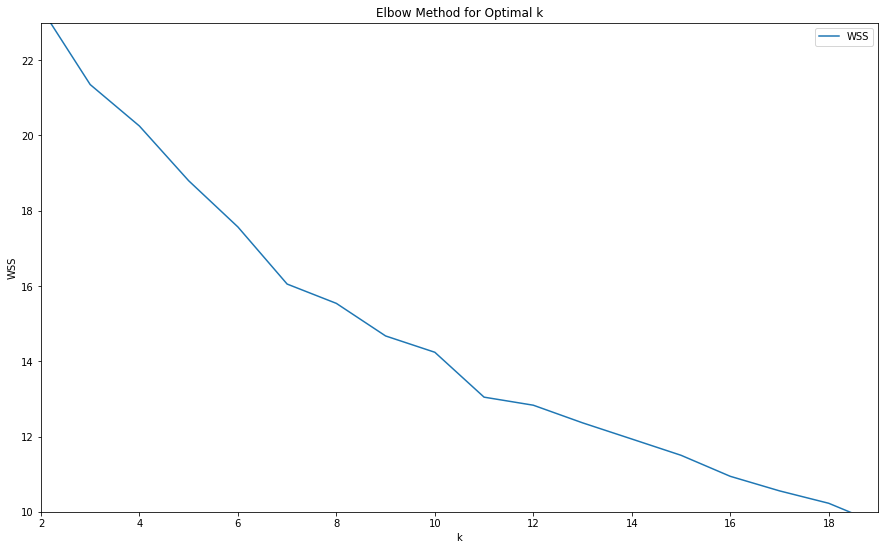

In [87]:
# try different numbers of clustering for London
kclusters = np.arange(2,20)
ylim = (10,23)
df_kmeans = get_wss_graph(kclusters, London_grouped, ylim)

In [88]:
df_kmeans['WSS Diff'] = df_kmeans['WSS'] - df_kmeans['WSS'].shift(1)
df_kmeans

,WSS,WSS Diff
K,,
2,23.388129,NaN
3,21.352778,-2.035352
4,20.250560,-1.102218
5,18.797207,-1.453353
6,17.569150,-1.228057
7,16.051433,-1.517717
8,15.538133,-0.513301
9,14.672616,-0.865516
10,14.239032,-0.433584


From above graph and table, it seem the number 5 Cluster is the best one.

In [89]:
kclusters = 11
kmeans_labels_ = get_kmeans_labels(London_grouped, kclusters)
London_merged = get_city_merged(kmeans_labels_, df_PostCode_adj, neighborhoods_venues_sorted)
London_merged.head()
full_clust = full_clustering(London_grouped, kclusters, df_PostCode_adj, neighborhoods_venues_sorted)
full_clust

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,SE2,"Bexley, Greenwich",Abbey Wood,51.4869,0.107500,8,Indian Restaurant,Playground,Pharmacy,Grocery Store,Food & Drink Shop,Flower Shop,Flea Market,Food Court,Fish Market,Fish & Chips Shop
1,W3,"Ealing, Hammersmith and Fulham",Acton,51.5114,-0.265717,0,Park,Pub,French Restaurant,Convenience Store,Grocery Store,Bakery,Gas Station,Train Station,Discount Store,Mini Golf
2,EC3,City,Aldgate,51.5085,-0.125700,3,Theater,Hotel,French Restaurant,Pub,Bakery,Pizza Place,Ice Cream Shop,Café,Plaza,Steakhouse
3,WC2,Westminster,Aldwych,51.5142,-0.123382,3,Theater,Coffee Shop,Ice Cream Shop,Bakery,Dessert Shop,Hotel,Clothing Store,Cosmetics Shop,Museum,Indian Restaurant
4,SE20,Bromley,Anerley,51.4154,-0.056950,1,Fast Food Restaurant,Pub,Supermarket,Pizza Place,Train Station,Platform,Café,Convenience Store,Garden Center,Grocery Store


In [90]:
London_merged.groupby('Cluster Labels').count()

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
1,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126
2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
5,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
7,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
8,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### Cluster in detail: 


### We can focus on  0, 1, 3 clusters.

In [92]:
London_merged.loc[London_merged['Cluster Labels'] == 0, 
               London_merged.columns[[1] + list(range(5, London_merged.shape[1]))]].head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Ealing, Hammersmith and Fulham",0,Park,Pub,French Restaurant,Convenience Store,Grocery Store,Bakery,Gas Station,Train Station,Discount Store,Mini Golf
12,Islington,0,Pub,Park,Café,Cocktail Bar,Gastropub,Grocery Store,Bakery,Trail,Boutique,Organic Grocery
27,Tower Hamlets,0,Pub,Grocery Store,Burger Joint,Rental Car Location,Locksmith,Light Rail Station,Bar,Coffee Shop,Park,Discount Store
33,Tower Hamlets,0,Pub,Grocery Store,Burger Joint,Rental Car Location,Locksmith,Light Rail Station,Bar,Coffee Shop,Park,Discount Store
44,Islington,0,Pub,Park,Café,Cocktail Bar,Gastropub,Grocery Store,Bakery,Trail,Boutique,Organic Grocery
53,Lewisham,0,Pub,Hotel,Café,Park,Film Studio,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
60,Barnet,0,Pub,Asian Restaurant,Café,Outdoor Supply Store,Park,Clothing Store,Ice Cream Shop,Dessert Shop,Dim Sum Restaurant,Food Court
73,Islington,0,Pub,Park,Café,Cocktail Bar,Gastropub,Grocery Store,Bakery,Trail,Boutique,Organic Grocery
79,Kensington and Chelsea,0,Pub,Italian Restaurant,Café,Pizza Place,Garden,Restaurant,Cupcake Shop,Speakeasy,Farmers Market,French Restaurant
81,Southwark,0,Pub,Vegetarian / Vegan Restaurant,Bus Stop,Café,Furniture / Home Store,Fish & Chips Shop,Gastropub,Thai Restaurant,Grocery Store,Convenience Store


In [93]:
London_merged.loc[London_merged['Cluster Labels'] == 1, 
               London_merged.columns[[1] + list(range(5, London_merged.shape[1]))]].head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bromley,1,Fast Food Restaurant,Pub,Supermarket,Pizza Place,Train Station,Platform,Café,Convenience Store,Garden Center,Grocery Store
6,Islington,1,Coffee Shop,Grocery Store,Pub,Café,Bar,Italian Restaurant,Pizza Place,Gastropub,Lounge,Bike Rental / Bike Share
11,Richmond upon Thames,1,Pub,Farmers Market,Grocery Store,French Restaurant,Train Station,Food & Drink Shop,Café,Gastropub,Park,Gym / Fitness Center
13,Wandsworth,1,Pub,Cocktail Bar,Café,Indian Restaurant,Coffee Shop,Grocery Store,Supermarket,Pizza Place,Portuguese Restaurant,French Restaurant
20,Tower Hamlets,1,Café,Vegetarian / Vegan Restaurant,Pizza Place,Coffee Shop,Cocktail Bar,Bakery,Pub,Art Gallery,Vietnamese Restaurant,Brewery
28,Haringey,1,Indian Restaurant,Café,Convenience Store,Fast Food Restaurant,Light Rail Station,Bar,Bakery,Train Station,Restaurant,Auto Garage
32,Lewisham,1,Convenience Store,Coffee Shop,Grocery Store,Beer Store,Café,Gastropub,Fish & Chips Shop,Furniture / Home Store,Brewery,Bus Stop
35,Brent,1,Coffee Shop,Pub,Café,Pizza Place,Middle Eastern Restaurant,Indian Restaurant,Bar,Korean Restaurant,Theater,Gastropub
38,Southwark,1,Grocery Store,Bakery,Café,Coffee Shop,Turkish Restaurant,Gym / Fitness Center,Beer Bar,Bus Stop,Gastropub,Pub
39,Tower Hamlets,1,Café,Vegetarian / Vegan Restaurant,Pizza Place,Coffee Shop,Cocktail Bar,Bakery,Pub,Art Gallery,Vietnamese Restaurant,Brewery


In [95]:
London_merged.loc[London_merged['Cluster Labels'] == 3, 
               London_merged.columns[[1] + list(range(5, London_merged.shape[1]))]].head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,City,3,Theater,Hotel,French Restaurant,Pub,Bakery,Pizza Place,Ice Cream Shop,Café,Plaza,Steakhouse
3,Westminster,3,Theater,Coffee Shop,Ice Cream Shop,Bakery,Dessert Shop,Hotel,Clothing Store,Cosmetics Shop,Museum,Indian Restaurant
5,Islington,3,Coffee Shop,Pub,Italian Restaurant,Sandwich Place,Wine Bar,French Restaurant,Burrito Place,Beer Bar,Restaurant,Café
8,Wandsworth,3,Fish & Chips Shop,Music Store,Garden,Tennis Court,Zoo Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio
9,Southwark,3,Pub,Coffee Shop,Italian Restaurant,Hotel,Wine Bar,Portuguese Restaurant,Restaurant,Seafood Restaurant,Food Truck,Modern European Restaurant
10,City,3,Coffee Shop,Pub,Italian Restaurant,Sandwich Place,Wine Bar,French Restaurant,Burrito Place,Beer Bar,Restaurant,Café
14,Westminster,3,Hotel,Pub,Chinese Restaurant,Greek Restaurant,Café,Coffee Shop,Garden,Ice Cream Shop,English Restaurant,Gym / Fitness Center
15,Ealing,3,Coffee Shop,Pub,Bakery,Café,Bookstore,Pizza Place,Bus Stop,Burger Joint,Ice Cream Shop,Grocery Store
16,Westminster,3,Hotel,Pub,Italian Restaurant,Café,Sandwich Place,Bakery,Grocery Store,Coffee Shop,Turkish Restaurant,Deli / Bodega
18,Camden,3,Coffee Shop,Hotel,Gym / Fitness Center,Café,Italian Restaurant,Pub,Hotel Bar,Department Store,Restaurant,Farmers Market


<h2>Conclusion: from above tables, we can roughly define:</h2>

<ol>
    <li>Cluster 0: parks with some resteraunts (mostly fast food) and pubs nearby.</li>
    <li>Cluster 1: fast food, pubs, coffee shops, farmers market and convenient stores</li>
    <li>Cluster 3: entertainments, all kinds of resteraunts, supermarkets and retail stores.</li>
</ol>

<hr>